In [17]:
import uuid
from enum import Enum
from collections import Counter
import deprecation
#from pm4py.objects.bpmn.obj import BPMN
from pm4py.util import constants
from pm4py import vis

# BPMN

Node←Annotation és Flow←Association leszármazásokkal 

In [18]:
DEFAULT_PROCESS = str(uuid.uuid4())


class Marking(Counter):
    pass

    # required = Counter()

    def __hash__(self):
        r = 0
        for p in self.items():
            r += 31 * hash(p[0]) * p[1]
        return r

    def __eq__(self, other):
        if not self.keys() == other.keys():
            return False
        for p in self.keys():
            if other.get(p) != self.get(p):
                return False
        return True

    def __le__(self, other):
        if not self.keys() <= other.keys():
            return False
        for p in self.keys():
            if sum(other.get(p)) < sum(self.get(p)):
                return False
        return True

    def __add__(self, other):
        m = Marking()
        for p in self.items():
            m[p[0]] = p[1]
        for p in other.items():
            m[p[0]] += p[1]
        return m

    def __sub__(self, other):
        m = Marking()
        for p in self.items():
            m[p[0]] = p[1]
        for p in other.items():
            m[p[0]] -= p[1]
            if m[p[0]] == 0:
                del m[p[0]]
        return m

    def __repr__(self):
        # return str([str(p.name) + ":" + str(self.get(p)) for p in self.keys()])
        # The previous representation had a bug, it took into account the order of the places with tokens
        return str([str(p.id) + ":" + str(self.get(p)) for p in sorted(list(self.keys()), key=lambda x: x.id)])

    def __deepcopy__(self, memodict={}):
        marking = Marking()
        memodict[id(self)] = marking
        for node in self:
            node_occ = self[node]
            new_node = memodict[id(node)] if id(node) in memodict else BPMN.BPMNNode(node.id, node.name)
            marking[new_node] = node_occ
        return marking


class BPMNNodeLayout(object):
    def __init__(self):
        self.__x = 0
        self.__y = 0
        self.__width = 100
        self.__height = 100

    def set_x(self, x):
        self.__x = x

    def set_y(self, y):
        self.__y = y

    def get_x(self):
        return self.__x

    def get_y(self):
        return self.__y

    def get_width(self):
        return self.__width

    def set_width(self, width):
        self.__width = width

    def get_height(self):
        return self.__height

    def set_height(self, height):
        self.__height = height


class BPMNEdgeLayout(object):
    def __init__(self):
        self.__waypoints = [(0, 0), (0, 0)]

    def add_waypoint(self, waypoint):
        self.__waypoints.append(waypoint)

    def del_waypoints(self):
        self.__waypoints = list()

    def get_waypoints(self):
        return self.__waypoints


class BPMNLayout(object):
    def __init__(self):
        self.layout_dict = {}

    def get(self, n):
        if n not in self.layout_dict:
            if isinstance(n, BPMN.BPMNNode):
                self.layout_dict[n] = BPMNNodeLayout()
            elif isinstance(n, BPMN.Flow):
                self.layout_dict[n] = BPMNEdgeLayout()
        return self.layout_dict[n]


class BPMN(object):
    class BPMNNode(object):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            self.__id = ("id" + str(uuid.uuid4())) if id == "" else id
            self.__name = name
            self.__in_arcs = list() if in_arcs is None else in_arcs
            self.__out_arcs = list() if out_arcs is None else out_arcs
            self.__process = DEFAULT_PROCESS if process == None else process
            self.__layout = BPMNLayout()

        def get_id(self):
            return self.__id

        def get_name(self):
            return self.__name

        def get_in_arcs(self):
            return self.__in_arcs

        def get_out_arcs(self):
            return self.__out_arcs

        def add_in_arc(self, in_arc):
            if in_arc not in self.__in_arcs:
                self.__in_arcs.append(in_arc)

        def add_out_arc(self, out_arc):
            if out_arc not in self.__out_arcs:
                self.__out_arcs.append(out_arc)

        def remove_in_arc(self, in_arc):
            self.__in_arcs.remove(in_arc)

        def remove_out_arc(self, out_arc):
            self.__out_arcs.remove(out_arc)

        def get_process(self):
            return self.__process

        def set_process(self, process):
            self.__process = process

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def set_x(self, x):
            return self.__layout.get(self).set_x(x)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def set_y(self, y):
            return self.__layout.get(self).set_y(y)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_x(self):
            return self.__layout.get(self).get_x()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_y(self):
            return self.__layout.get(self).get_y()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_width(self):
            return self.__layout.get(self).get_width()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def set_width(self, width):
            return self.__layout.get(self).set_width(width)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_height(self):
            return self.__layout.get(self).get_height()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def set_height(self, height):
            return self.__layout.get(self).set_height(height)

        def get_layout(self):
            return self.__layout

        def set_layout(self, layout):
            self.__layout = layout

        def __hash__(self):
            return hash(self.id)

        def __eq__(self, other):
            # keep the ID for now in places
            return hash(self) == hash(other)

        def __repr__(self):
            return str(self.__id + "@" + self.__name)

        def __str__(self):
            return self.__repr__()

        name = property(get_name)
        id = property(get_id)
        in_arcs = property(get_in_arcs)
        out_arcs = property(get_out_arcs)
        process = property(get_process, set_process)

        
    class TextAnnotation(BPMNNode):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.BPMNNode.__init__(self, id, name, in_arcs, out_arcs, process=process)
            
    class Event(BPMNNode):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.BPMNNode.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class StartEvent(Event):
        def __init__(self, id="", isInterrupting=False, name="", parallelMultiple=False, in_arcs=None, out_arcs=None,
                     process=None):
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)
            self.__isInterrupting = isInterrupting
            self.__parallelMultiple = parallelMultiple

        def get_isInterrupting(self):
            return self.__isInterrupting

        def get_parallelMultiple(self):
            return self.__parallelMultiple

    class NormalStartEvent(StartEvent):
        def __init__(self, id="", isInterrupting=False, name="", parallelMultiple=False, in_arcs=None, out_arcs=None,
                     process=None):
            BPMN.StartEvent.__init__(self, id, isInterrupting, name, parallelMultiple, in_arcs, out_arcs,
                                     process=process)

    class MessageStartEvent(StartEvent):
        def __init__(self, id="", isInterrupting=False, name="", parallelMultiple=False, in_arcs=None, out_arcs=None,
                     process=None):
            BPMN.StartEvent.__init__(self, id, isInterrupting, name, parallelMultiple, in_arcs, out_arcs,
                                     process=process)

    class IntermediateCatchEvent(Event):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class MessageIntermediateCatchEvent(IntermediateCatchEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateCatchEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class ErrorIntermediateCatchEvent(IntermediateCatchEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateCatchEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class CancelIntermediateCatchEvent(IntermediateCatchEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateCatchEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class BoundaryEvent(Event):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, activity=None):
            self.__activity = activity
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)

        def get_activity(self):
            return self.__activity

    class MessageBoundaryEvent(BoundaryEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, activity=None):
            BPMN.BoundaryEvent.__init__(self, id, name, in_arcs, out_arcs, process=process, activity=activity)

    class ErrorBoundaryEvent(BoundaryEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, activity=None):
            BPMN.BoundaryEvent.__init__(self, id, name, in_arcs, out_arcs, process=process, activity=activity)

    class CancelBoundaryEvent(BoundaryEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, activity=None):
            BPMN.BoundaryEvent.__init__(self, id, name, in_arcs, out_arcs, process=process, activity=activity)

    class IntermediateThrowEvent(Event):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class MessageIntermediateThrowEvent(IntermediateThrowEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateThrowEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class NormalIntermediateThrowEvent(IntermediateThrowEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateThrowEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class EndEvent(Event):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class NormalEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class MessageEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class TerminateEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class ErrorEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class CancelEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class Activity(BPMNNode):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.BPMNNode.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class Task(Activity):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.Activity.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class SubProcess(Activity):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, depth=None):
            self.__depth = depth
            BPMN.Activity.__init__(self, id, name, in_arcs, out_arcs, process=process)

        def get_depth(self):
            return self.__depth

    class Gateway(BPMNNode):
        class Direction(Enum):
            UNSPECIFIED = "Unspecified"
            DIVERGING = "Diverging"
            CONVERGING = "Converging"

        def __init__(self, id="", name="", gateway_direction=Direction.UNSPECIFIED, in_arcs=None, out_arcs=None,
                     process=None):
            BPMN.BPMNNode.__init__(self, id, name, in_arcs, out_arcs, process=process)
            self.__gateway_direction = gateway_direction

        def get_gateway_direction(self):
            return self.__gateway_direction

        def set_gateway_direction(self, direction):
            self.__gateway_direction = direction

    class ParallelGateway(Gateway):
        def __init__(self, id="", name="", gateway_direction=None, in_arcs=None, out_arcs=None, process=None):
            gateway_direction = gateway_direction if gateway_direction is not None else BPMN.Gateway.Direction.UNSPECIFIED
            BPMN.Gateway.__init__(self, id, name, gateway_direction, in_arcs, out_arcs, process=process)

    class ExclusiveGateway(Gateway):
        def __init__(self, id="", name="", gateway_direction=None, in_arcs=None, out_arcs=None, process=None):
            gateway_direction = gateway_direction if gateway_direction is not None else BPMN.Gateway.Direction.UNSPECIFIED
            BPMN.Gateway.__init__(self, id, name, gateway_direction, in_arcs, out_arcs, process=process)

    class InclusiveGateway(Gateway):
        def __init__(self, id="", name="", gateway_direction=None, in_arcs=None, out_arcs=None, process=None):
            gateway_direction = gateway_direction if gateway_direction is not None else BPMN.Gateway.Direction.UNSPECIFIED
            BPMN.Gateway.__init__(self, id, name, gateway_direction, in_arcs, out_arcs, process=process)
            
    class Flow(object):
        def __init__(self, source, target, id="", name="", process=None):
            self.__id = uuid.uuid4() if id == "" else id
            self.__name = name
            self.__source = source
            source.add_out_arc(self)
            self.__target = target
            target.add_in_arc(self)
            self.__process = DEFAULT_PROCESS if process == None else process
            self.__layout = BPMNLayout()

        def get_id(self):
            return self.__id

        def get_name(self):
            return self.__name

        def get_source(self):
            return self.__source

        def get_target(self):
            return self.__target

        def get_process(self):
            return self.__process

        def set_process(self, process):
            self.__process = process

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def add_waypoint(self, waypoint):
            return self.__layout.get(self).add_waypoint(waypoint)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def del_waypoints(self):
            return self.__layout.get(self).del_waypoints()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_waypoints(self):
            return self.__layout.get(self).get_waypoints()

        def get_layout(self):
            return self.__layout

        def set_layout(self, layout):
            self.__layout = layout

        def __repr__(self):
            u_id = str(self.__source.get_id()) + "@" + str(self.__source.get_name())
            v_id = str(self.__target.get_id()) + "@" + str(self.__target.get_name())
            return u_id + " -> " + v_id

        def __str__(self):
            return self.__repr__()

        source = property(get_source)
        target = property(get_target)

    class SequenceFlow(Flow):
        def __init__(self, source, target, id="", name="", process=None):
            BPMN.Flow.__init__(self, source, target, id=id, name=name, process=process)

    class MessageFlow(Flow):
        def __init__(self, source, target, id="", name="", process=None):
            BPMN.Flow.__init__(self, source, target, id=id, name=name, process=process)

    class AssociationFlow(Flow):
        def __init__(self, source, target, id="", name="", process=None):
            BPMN.Flow.__init__(self, source, target, id=id, name=name, process=process)

    def __init__(self, process_id=None, name="", nodes=None, flows=None):
        import networkx as nx

        self.__process_id = str(uuid.uuid4()) if process_id == None else process_id

        self.__name = name
        self.__graph = nx.MultiDiGraph()
        self.__nodes = set() if nodes is None else nodes
        self.__flows = set() if flows is None else flows
        self.__layout = BPMNLayout()

        if nodes is not None:
            for node in nodes:
                node.set_layout(self.get_layout())
                self.__graph.add_node(node)
        if flows is not None:
            for flow in flows:
                flow.set_layout(self.get_layout())
                self.__graph.add_edge(flow.get_source(), flow.get_target())
    
    def get_process_id(self):
        return self.__process_id

    def set_process_id(self, process_id):
        self.__process_id = process_id

    def get_nodes(self):
        return self.__nodes

    def get_flows(self):
        return self.__flows

    def get_graph(self):
        return self.__graph

    def get_name(self):
        return self.__name

    def add_node(self, node):
        node.set_layout(self.get_layout())
        self.__nodes.add(node)
        self.__graph.add_node(node)

    def remove_node(self, node):
        if node in self.__nodes:
            self.__nodes.remove(node)
            self.__graph.remove_node(node)

    def remove_flow(self, flow):
        source = flow.get_source()
        target = flow.get_target()
        if source in self.__nodes:
            source.remove_out_arc(flow)
        if target in self.__nodes:
            target.remove_in_arc(flow)
        self.__flows.remove(flow)
        self.__graph.remove_edge(source, target)

    def add_flow(self, flow):
        if not isinstance(flow, BPMN.Flow):
            raise Exception()
        flow.set_layout(self.get_layout())
        source = flow.get_source()
        target = flow.get_target()
        if source not in self.__nodes:
            self.add_node(source)
        if target not in self.__nodes:
            self.add_node(target)
        self.__flows.add(flow)
        self.__graph.add_edge(source, target, id=flow.get_id(), name=flow.get_name())
        source.add_out_arc(flow)
        target.add_in_arc(flow)

    def get_layout(self):
        return self.__layout

    def set_layout(self, layout):
        self.__layout = layout
        for n in self.__nodes:
            n.set_layout(layout)
        for e in self.__flows:
            e.set_layout(layout)


Parse BPMN

In [19]:

class Counts:
    def __init__(self):
        self.number_processes = 0


def parse_element(bpmn_graph, counts, curr_el, parents, incoming_dict, outgoing_dict, nodes_dict, nodes_bounds,
                  flow_info, process=None, node=None, bpmn_element=None, flow=None, rec_depth=0):
    """
    Parses a BPMN element from the XML file
    """
    layout = bpmn_graph.get_layout()
    tag = curr_el.tag.lower()
    if tag.endswith("subprocess"): # subprocess invocation
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        subprocess = BPMN.SubProcess(id=curr_el.get("id"), name=name, process=process, depth=rec_depth)
        bpmn_graph.add_node(subprocess)
        node = subprocess
        process = curr_el.get("id")
        nodes_dict[process] = node
    elif tag.endswith("process"): # process of the current subtree
        process = curr_el.get("id")
        bpmn_graph.set_process_id(process)
    elif tag.endswith("shape"): # shape of a node, contains x,y,width,height information
        bpmn_element = curr_el.get("bpmnElement")
    elif tag.endswith("task"): # simple task object
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        #this_type = str(curr_el.tag)
        #this_type = this_type[this_type.index("}") + 1:]
        task = BPMN.Task(id=id, name=name, process=process)
        bpmn_graph.add_node(task)
        node = task
        nodes_dict[id] = node
    elif tag.endswith("startevent"): # start node starting the (sub)process
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if  event_type.endswith("message"):
                start_event = BPMN.MessageStartEvent(id=curr_el.get("id"), name=name, process=process)
            else: # TODO: expand functionality, support more start event types
                start_event = BPMN.NormalStartEvent(id=curr_el.get("id"), name=name, process=process)
        else:
            start_event = BPMN.NormalStartEvent(id=curr_el.get("id"), name=name, process=process)
        bpmn_graph.add_node(start_event)
        node = start_event
        nodes_dict[id] = node
    elif tag.endswith("endevent"): # end node ending the (sub)process
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        print(name)
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if  event_type.endswith("message"):
                end_event = BPMN.MessageEndEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("terminate"):
                end_event = BPMN.TerminateEndEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("error"):
                end_event = BPMN.ErrorEndEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("cancel"):
                end_event = BPMN.CancelEndEvent(id=curr_el.get("id"), name=name, process=process)
            else: # TODO: expand functionality, support more start event types
                end_event = BPMN.NormalEndEvent(id=curr_el.get("id"), name=name, process=process)
        else:
            end_event = BPMN.NormalEndEvent(id=curr_el.get("id"), name=name, process=process)
        bpmn_graph.add_node(end_event)
        node = end_event
        nodes_dict[id] = node
    elif tag.endswith("intermediatecatchevent"): # intermediate event that happens (externally) and can be catched
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if  event_type.endswith("message"):
                intermediate_catch_event = BPMN.MessageIntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("error"):
                intermediate_catch_event = BPMN.ErrorIntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("cancel"):
                intermediate_catch_event = BPMN.CancelIntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
            else:
                intermediate_catch_event = BPMN.IntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
        else:
            intermediate_catch_event = BPMN.IntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
        bpmn_graph.add_node(intermediate_catch_event)
        node = intermediate_catch_event
        nodes_dict[id] = node
    elif tag.endswith("intermediatethrowevent"): # intermediate event that is activated through the (sub)process
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if  event_type.endswith("message"):
                intermediate_throw_event = BPMN.MessageIntermediateThrowEvent(id=curr_el.get("id"), name=name, process=process)
            else:
                intermediate_throw_event = BPMN.NormalIntermediateThrowEvent(id=curr_el.get("id"), name=name, process=process)
        else:
            intermediate_throw_event = BPMN.NormalIntermediateThrowEvent(id=curr_el.get("id"), name=name, process=process)
        bpmn_graph.add_node(intermediate_throw_event)
        node = intermediate_throw_event
        nodes_dict[id] = node
    elif tag.endswith("boundaryevent"):
        id = curr_el.get("id")
        ref_activity = curr_el.get("attachedToRef")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if event_type.endswith("message"):
                boundary_event = BPMN.MessageBoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
            elif  event_type.endswith("error"):
                boundary_event = BPMN.ErrorBoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
            elif  event_type.endswith("cancel"):
                boundary_event = BPMN.CancelBoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
            else:
                boundary_event = BPMN.BoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
        else:
            boundary_event = BPMN.BoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
        bpmn_graph.add_node(boundary_event)
        node = boundary_event
        nodes_dict[id] = node
    elif tag.endswith("edge"): # related to the x, y information of an arc
        bpmnElement = curr_el.get("bpmnElement")
        flow = bpmnElement
    elif tag.endswith("exclusivegateway"):
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        try:
            direction = BPMN.Gateway.Direction[curr_el.get("gatewayDirection").upper()]
            exclusive_gateway = BPMN.ExclusiveGateway(id=curr_el.get("id"), name=name, gateway_direction=direction, process=process)
        except:
            exclusive_gateway = BPMN.ExclusiveGateway(id=curr_el.get("id"), name=name, gateway_direction=BPMN.Gateway.Direction.UNSPECIFIED, process=process)
        bpmn_graph.add_node(exclusive_gateway)
        node = exclusive_gateway
        nodes_dict[id] = node
    elif tag.endswith("parallelgateway"):
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        try:
            direction = BPMN.Gateway.Direction[curr_el.get("gatewayDirection").upper()]
            parallel_gateway = BPMN.ParallelGateway(id=curr_el.get("id"), name=name, gateway_direction=direction, process=process)
        except:
            parallel_gateway = BPMN.ParallelGateway(id=curr_el.get("id"), name=name, gateway_direction=BPMN.Gateway.Direction.UNSPECIFIED, process=process)
        bpmn_graph.add_node(parallel_gateway)
        node = parallel_gateway
        nodes_dict[id] = node
    elif tag.endswith("inclusivegateway"):
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        try:
            direction = BPMN.Gateway.Direction[curr_el.get("gatewayDirection").upper()]
            inclusive_gateway = BPMN.InclusiveGateway(id=curr_el.get("id"), name=name, gateway_direction=direction, process=process)
        except:
            inclusive_gateway = BPMN.InclusiveGateway(id=curr_el.get("id"), name=name, gateway_direction=BPMN.Gateway.Direction.UNSPECIFIED, process=process)
        bpmn_graph.add_node(inclusive_gateway)
        node = inclusive_gateway
        nodes_dict[id] = node
    elif tag.endswith("incoming"): # incoming flow of a node
        if node is not None:
            incoming_dict[curr_el.text.strip()] = (node, process, tag)
    elif tag.endswith("outgoing"): # outgoing flow of a node
        if node is not None:
            outgoing_dict[curr_el.text.strip()] = (node, process, tag)
    elif tag.endswith("sequenceflow"): # normal sequence flow between two nodes
        seq_flow_id = curr_el.get("id")
        source_ref = curr_el.get("sourceRef")
        target_ref = curr_el.get("targetRef")
        if source_ref is not None and target_ref is not None:
            incoming_dict[seq_flow_id] = (target_ref, process, tag)
            outgoing_dict[seq_flow_id] = (source_ref, process, tag)
    elif tag.endswith("waypoint"): # contains information of x, y values of an edge
        if flow is not None:
            x = float(curr_el.get("x"))
            y = float(curr_el.get("y"))
            if not flow in flow_info:
                flow_info[flow] = []
            flow_info[flow].append((x, y))
    elif tag.endswith("label"): # label of a node, mostly at the end of a shape object
        bpmn_element = None
    elif tag.endswith("bounds"): # contains information of width, height, x, y of a node
        if bpmn_element is not None:
            x = float(curr_el.get("x"))
            y = float(curr_el.get("y"))
            width = float(curr_el.get("width"))
            height = float(curr_el.get("height"))
            nodes_bounds[bpmn_element] = {"x": x, "y": y, "width": width, "height": height}
    #BCS
    elif tag.endswith("textannotation"):
        print('Text found!')
        text = [child.text for child in curr_el if child.tag.lower().endswith("text")]
        if(text[0] == 'Detailed'):
            print('Det')
            
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        print(name)
        annotation = BPMN.TextAnnotation(id=curr_el.get("id"), name=text[0], process=process)
        print(annotation)
        print(type(annotation))
        bpmn_graph.add_node(annotation)
        node = annotation
        nodes_dict[id] = node
    #BCS
    elif tag.endswith("association"): # association node and text annotation
        assoc_id = curr_el.get("id")
        source_ref = curr_el.get("sourceRef")
        target_ref = curr_el.get("targetRef")
        if source_ref is not None and target_ref is not None:
            incoming_dict[assoc_id] = (target_ref, process, tag)
            outgoing_dict[assoc_id] = (source_ref, process, tag)
        
        
        

    for child in curr_el:
        bpmn_graph = parse_element(bpmn_graph, counts, child, list(parents) + [child], incoming_dict, outgoing_dict,
                                   nodes_dict, nodes_bounds, flow_info, process=process, node=node,
                                   bpmn_element=bpmn_element,
                                   flow=flow, rec_depth=rec_depth + 1)
    # afterprocessing when the xml tree has been recursively parsed already
    if rec_depth == 0:
        # bpmn_graph.set_process_id(process)
        for seq_flow_id in incoming_dict:
            if incoming_dict[seq_flow_id][0] in nodes_dict:
                incoming_dict[seq_flow_id] = (nodes_dict[incoming_dict[seq_flow_id][0]], incoming_dict[seq_flow_id][1], incoming_dict[seq_flow_id][2])
        for seq_flow_id in outgoing_dict:
            if outgoing_dict[seq_flow_id][0] in nodes_dict:
                outgoing_dict[seq_flow_id] = (nodes_dict[outgoing_dict[seq_flow_id][0]], outgoing_dict[seq_flow_id][1], outgoing_dict[seq_flow_id][2])
        for flow_id in flow_info:
            if flow_id in outgoing_dict and flow_id in incoming_dict:
                if isinstance(outgoing_dict[flow_id][0], BPMN.BPMNNode) and isinstance(incoming_dict[flow_id][0], BPMN.BPMNNode):
                    flow = BPMN.SequenceFlow(outgoing_dict[flow_id][0], incoming_dict[flow_id][0], id=flow_id, name="", process=outgoing_dict[flow_id][1])
                    bpmn_graph.add_flow(flow)
                    layout.get(flow).del_waypoints()
                    for waypoint in flow_info[flow_id]:
                        layout.get(flow).add_waypoint(waypoint)
        for node_id in nodes_bounds:
            if node_id in nodes_dict:
                bounds = nodes_bounds[node_id]
                node = nodes_dict[node_id]
                layout.get(node).set_x(bounds["x"])
                layout.get(node).set_y(bounds["y"])
                layout.get(node).set_width(bounds["width"])
                layout.get(node).set_height(bounds["height"])
    return bpmn_graph


def import_xml_tree_from_root(root):
    """
    Imports a BPMN graph from (the root of) an XML tree

    Parameters
    -------------
    root
        Root of the tree

    Returns
    -------------
    bpmn_graph
        BPMN graph
    """
    bpmn_graph = BPMN()
    counts = Counts()
    incoming_dict = {}
    outgoing_dict = {}
    nodes_dict = {}
    nodes_bounds = {}
    flow_info = {}

    return parse_element(bpmn_graph, counts, root, [], incoming_dict, outgoing_dict, nodes_dict, nodes_bounds,
                         flow_info)


def apply2(path, parameters=None):
    """
    Imports a BPMN diagram from a file

    Parameters
    -------------
    path
        Path to the file
    parameters
        Parameters of the algorithm

    Returns
    -------------
    bpmn_graph
        BPMN graph
    """
    if parameters is None:
        parameters = {}

    from lxml import etree, objectify

    parser = etree.XMLParser(remove_comments=True)
    xml_tree = objectify.parse(path, parser=parser)

    return import_xml_tree_from_root(xml_tree.getroot())


def import_from_string(bpmn_string, parameters=None):
    """
    Imports a BPMN diagram from a string

    Parameters
    -------------
    path
        Path to the file
    parameters
        Parameters of the algorithm

    Returns
    -------------
    bpmn_graph
        BPMN graph
    """
    if parameters is None:
        parameters = {}

    if type(bpmn_string) is str:
        bpmn_string = bpmn_string.encode(constants.DEFAULT_ENCODING)

    from lxml import etree, objectify

    parser = etree.XMLParser(remove_comments=True)
    root = objectify.fromstring(bpmn_string, parser=parser)

    return import_xml_tree_from_root(root)

In [20]:
bp_ex = apply2("running_example_annotated.bpmn")


Text found!
Det

TextAnnotation_158rgq9@Detailed
<class '__main__.BPMN.TextAnnotation'>
Text found!

TextAnnotation_1t0azjs@Brief
<class '__main__.BPMN.TextAnnotation'>


In [21]:

from graphviz import Digraph
from typing import Optional, Dict, Any, Union, Tuple
import graphviz
from pm4py.util import exec_utils
import tempfile
from pm4py.visualization.common import gview

In [22]:
class Parameters(Enum):
    FORMAT = "format"
    RANKDIR = "rankdir"
    FONT_SIZE = "font_size"
    BGCOLOR = "bgcolor"

In [27]:
#BPMN visualizer classic
def apply3(bpmn_graph: BPMN, parameters: Optional[Dict[Any, Any]] = None) -> graphviz.Digraph:
    """
    Visualize a BPMN graph

    Parameters
    -------------
    bpmn_graph
        BPMN graph
    parameters
        Parameters of the visualization, including:
         - Parameters.FORMAT: the format of the visualization
         - Parameters.RANKDIR: the direction of the representation (default: LR)

    Returns
    ------------
    gviz
        Graphviz representation
    """
    if parameters is None:
        parameters = {}

    #from pm4py.objects.bpmn.obj import BPMN
    from pm4py.objects.bpmn.util.sorting import get_sorted_nodes_edges

    image_format = exec_utils.get_param_value(Parameters.FORMAT, parameters, "png")
    rankdir = exec_utils.get_param_value(Parameters.RANKDIR, parameters, "LR")
    font_size = exec_utils.get_param_value(Parameters.FONT_SIZE, parameters, 12)
    font_size = str(font_size)
    bgcolor = exec_utils.get_param_value(Parameters.BGCOLOR, parameters, constants.DEFAULT_BGCOLOR)

    filename = tempfile.NamedTemporaryFile(suffix='.gv')
    viz = Digraph("", filename=filename.name, engine='dot', graph_attr={'bgcolor': bgcolor})
    viz.graph_attr['rankdir'] = rankdir

    nodes, edges = get_sorted_nodes_edges(bpmn_graph)

    for n in nodes:
        n_id = str(id(n))
        if isinstance(n, BPMN.Task):
            viz.node(n_id, shape="box", label=n.get_name(), fontsize=font_size)
        elif isinstance(n, BPMN.StartEvent):
            viz.node(n_id, label="", shape="circle", style="filled", fillcolor="green", fontsize=font_size)
        elif isinstance(n, BPMN.EndEvent):
            viz.node(n_id, label="", shape="circle", style="filled", fillcolor="orange", fontsize=font_size)
        elif isinstance(n, BPMN.ParallelGateway):
            viz.node(n_id, label="+", shape="diamond", fontsize=font_size)
        elif isinstance(n, BPMN.ExclusiveGateway):
            viz.node(n_id, label="X", shape="diamond", fontsize=font_size)
        elif isinstance(n, BPMN.InclusiveGateway):
            viz.node(n_id, label="O", shape="diamond", fontsize=font_size)
        elif isinstance(n, BPMN.TextAnnotation):
            viz.node(n_id, label=n.get_name(), shape="note", fontsize=font_size)
        else:
            viz.node(n_id, label="", shape="circle", fontsize=font_size)

    for e in edges:
        n_id_1 = str(id(e[0]))
        n_id_2 = str(id(e[1]))

        viz.edge(n_id_1, n_id_2)

    viz.attr(overlap='false')

    viz.format = image_format.replace("html", "plain-ext")

    return viz

In [28]:
def view(gviz: graphviz.Digraph, parameters=None):
    """
    View the diagram

    Parameters
    -----------
    gviz
        GraphViz diagram
    """
    return gview.view(gviz, parameters=parameters)

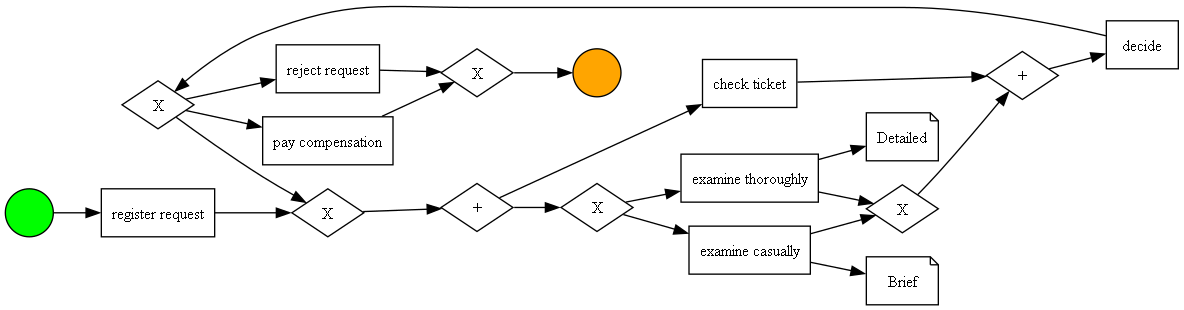

In [29]:
gv = apply3(bp_ex, parameters=None)
view(gv)

Petri net conversion

In [11]:
import uuid
from enum import Enum

from pm4py.objects.petri_net.utils import reduction
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to
from pm4py.util import exec_utils


class Parameters(Enum):
    USE_ID = "use_id"
    ENABLE_REDUCTION = "enable_reduction"
    RETURN_FLOW_TRANS_MAP = "return_flow_trans_map"

In [12]:
def build_digraph_from_petri_net(net):
    """
    Builds a directed graph from a Petri net
        (for the purpose to add invisibles between inclusive gateways)

    Parameters
    -------------
    net
        Petri net

    Returns
    -------------
    digraph
        Digraph
    """
    import networkx as nx
    graph = nx.DiGraph()
    for place in net.places:
        graph.add_node(place.name)
    for trans in net.transitions:
        in_places = [x.source for x in list(trans.in_arcs)]
        out_places = [x.target for x in list(trans.out_arcs)]
        for pl1 in in_places:
            for pl2 in out_places:
                graph.add_edge(pl1.name, pl2.name)
    return graph

def apply_topetri(bpmn_graph, parameters=None):
    """
    Converts a BPMN graph to an accepting Petri net

    Parameters
    --------------
    bpmn_graph
        BPMN graph
    parameters
        Parameters of the algorithm:
        - Parameters.USE_ID => (default: False) uses the IDs of the objects instead of their labels in the conversion
        - Parameters.ENABLE_REDUCTION => reduces the invisible transitions
        - Parameters.RETURN_FLOW_TRANS_MAP => returns additional information on the conversion:
                                                (iv) the places of the obtained Petri net that are corresponding to each
                                                    BPMN flow.
                                                (v) the transitions of the Petri net related to the nodes of the BPMN
                                                    diagram.

    Returns
    --------------
    net
        Petri net
    im
        Initial marking
    fm
        Final marking
    """
    if parameters is None:
        parameters = {}

    import networkx as nx
    from pm4py.objects.bpmn.obj import BPMN

    use_id = exec_utils.get_param_value(Parameters.USE_ID, parameters, False)
    return_flow_trans_map = exec_utils.get_param_value(Parameters.RETURN_FLOW_TRANS_MAP, parameters, False)
    enable_reduction = exec_utils.get_param_value(Parameters.ENABLE_REDUCTION, parameters, True)

    if return_flow_trans_map:
        enable_reduction = False

    net = PetriNet("")
    source_place = PetriNet.Place("source")
    net.places.add(source_place)
    sink_place = PetriNet.Place("sink")
    net.places.add(sink_place)
    im = Marking()
    fm = Marking()
    im[source_place] = 1
    fm[sink_place] = 1

    # keep this correspondence for adding invisible transitions for OR-gateways
    inclusive_gateway_exit = set()
    inclusive_gateway_entry = set()

    flow_place = {}
    source_count = {}
    target_count = {}
    for flow in bpmn_graph.get_flows():
        source = flow.get_source()
        target = flow.get_target()
        place = PetriNet.Place(str(flow.get_id()))
        net.places.add(place)
        flow_place[flow] = place
        if source not in source_count:
            source_count[source] = 0
        if target not in target_count:
            target_count[target] = 0
        source_count[source] = source_count[source] + 1
        target_count[target] = target_count[target] + 1

    for flow in bpmn_graph.get_flows():
        source = flow.get_source()
        target = flow.get_target()
        place = PetriNet.Place(str(flow.get_id()))
        if isinstance(source, BPMN.InclusiveGateway) and source_count[source] > 1:
            inclusive_gateway_exit.add(place.name)
        elif isinstance(target, BPMN.InclusiveGateway) and target_count[target] > 1:
            inclusive_gateway_entry.add(place.name)

    # remove possible places that are both in inclusive_gateway_exit and inclusive_gateway_entry,
    # because we do not need to add invisibles in this situation
    incl_gat_set_inters = inclusive_gateway_entry.intersection(inclusive_gateway_exit)
    inclusive_gateway_exit = inclusive_gateway_exit.difference(incl_gat_set_inters)
    inclusive_gateway_entry = inclusive_gateway_entry.difference(incl_gat_set_inters)

    nodes_entering = {}
    nodes_exiting = {}
    trans_map = {}

    for node in bpmn_graph.get_nodes():
        entry_place = PetriNet.Place("ent_" + str(node.get_id()))
        net.places.add(entry_place)
        exiting_place = PetriNet.Place("exi_" + str(node.get_id()))
        net.places.add(exiting_place)
        if use_id:
            label = str(node.get_id())
        else:
            label = str(node.get_name()) if isinstance(node, BPMN.Task) else None
            if not label:
                label = None
        transition = PetriNet.Transition(name=str(node.get_id()), label=label)
        net.transitions.add(transition)
        trans_map[node] = [transition]
        add_arc_from_to(entry_place, transition, net)
        add_arc_from_to(transition, exiting_place, net)

        if isinstance(node, BPMN.ParallelGateway) or isinstance(node, BPMN.InclusiveGateway):
            if source_count[node] > 1:
                exiting_object = PetriNet.Transition(str(uuid.uuid4()), None)
                net.transitions.add(exiting_object)
                add_arc_from_to(exiting_place, exiting_object, net)
                trans_map[node].append(exiting_object)
            else:
                exiting_object = exiting_place

            if target_count[node] > 1:
                entering_object = PetriNet.Transition(str(uuid.uuid4()), None)
                net.transitions.add(entering_object)
                add_arc_from_to(entering_object, entry_place, net)
                trans_map[node].append(entering_object)
            else:
                entering_object = entry_place
            nodes_entering[node] = entering_object
            nodes_exiting[node] = exiting_object
        else:
            nodes_entering[node] = entry_place
            nodes_exiting[node] = exiting_place

        if isinstance(node, BPMN.StartEvent):
            start_transition = PetriNet.Transition(str(uuid.uuid4()), None)
            net.transitions.add(start_transition)
            add_arc_from_to(source_place, start_transition, net)
            add_arc_from_to(start_transition, entry_place, net)
            trans_map[node].append(start_transition)
        elif isinstance(node, BPMN.EndEvent):
            end_transition = PetriNet.Transition(str(uuid.uuid4()), None)
            net.transitions.add(end_transition)
            add_arc_from_to(exiting_place, end_transition, net)
            add_arc_from_to(end_transition, sink_place, net)
            trans_map[node].append(end_transition)

    for flow in bpmn_graph.get_flows():
        source_object = nodes_exiting[flow.get_source()]
        target_object = nodes_entering[flow.get_target()]

        if isinstance(source_object, PetriNet.Place):
            inv1 = PetriNet.Transition(f"sfl_{flow.get_id()}", None)
            net.transitions.add(inv1)
            add_arc_from_to(source_object, inv1, net)
            source_object = inv1
            trans_map[flow.source].append(inv1)

        if isinstance(target_object, PetriNet.Place):
            inv2 = PetriNet.Transition(f"tfl_{flow.get_id()}", None)
            net.transitions.add(inv2)
            add_arc_from_to(inv2, target_object, net)
            target_object = inv2
            trans_map[flow.target].append(inv2)

        add_arc_from_to(source_object, flow_place[flow], net)
        add_arc_from_to(flow_place[flow], target_object, net)

    if inclusive_gateway_exit and inclusive_gateway_entry:
        # do the following steps if there are inclusive gateways:
        # - calculate the shortest paths
        # - add an invisible transition between couples of corresponding places
        # this ensures soundness and the correct translation of the BPMN
        inv_places = {x.name: x for x in net.places}
        digraph = build_digraph_from_petri_net(net)
        all_shortest_paths = dict(nx.all_pairs_dijkstra(digraph))
        keys = list(all_shortest_paths.keys())

        for pl1 in inclusive_gateway_exit:
            if pl1 in keys:
                output_places = sorted(
                    [(x, len(y)) for x, y in all_shortest_paths[pl1][1].items() if x in inclusive_gateway_entry],
                    key=lambda x: x[1])
                if output_places:
                    inv_trans = PetriNet.Transition(str(uuid.uuid4()), None)
                    net.transitions.add(inv_trans)
                    add_arc_from_to(inv_places[pl1], inv_trans, net)
                    add_arc_from_to(inv_trans, inv_places[output_places[0][0]], net)

    if enable_reduction:
        reduction.apply_simple_reduction(net)

    if return_flow_trans_map:
        return net, im, fm, flow_place, trans_map

    return net, im, fm


In [13]:
pn, i, f = apply_topetri(bp_ex)

In [14]:
pn

places: [ ent_Gateway_03rsq5y, ent_Gateway_0b0vggc, ent_Gateway_1cgtqfa, ent_Gateway_1rxp8wq, ent_StartEvent_1, exi_Activity_114fwgn, exi_Activity_1rpdqbz, exi_Event_0ivv4nr, exi_Gateway_0ltnp7l, exi_Gateway_0uizhj1, exi_Gateway_18qrdzs, exi_TextAnnotation_158rgq9, exi_TextAnnotation_1t0azjs, sink, source ]
transitions: [ (Gateway_03rsq5y, None), (Gateway_0b0vggc, None), (Gateway_1cgtqfa, None), (Gateway_1rxp8wq, None), (StartEvent_1, None), (sfl_Association_0zz54yd, None), (sfl_Association_1ib3yds, None), (sfl_Flow_02e8t1b, None), (sfl_Flow_07d44sk, None), (sfl_Flow_0avskfk, None), (sfl_Flow_0d4cyx0, None), (sfl_Flow_0f0on65, None), (sfl_Flow_10kbwgk, None), (sfl_Flow_1lbzzzm, None), (sfl_Flow_1rv4ge1, None), (sfl_Flow_1x1dvj2, None) ]
arcs: [ (Gateway_03rsq5y, None)->exi_Gateway_0uizhj1, (Gateway_0b0vggc, None)->exi_Gateway_0ltnp7l, (Gateway_1cgtqfa, None)->exi_Event_0ivv4nr, (Gateway_1rxp8wq, None)->ent_Gateway_03rsq5y, (StartEvent_1, None)->ent_Gateway_0b0vggc, (sfl_Association_0zz

In [15]:
from pm4py.vis import view_petri_net

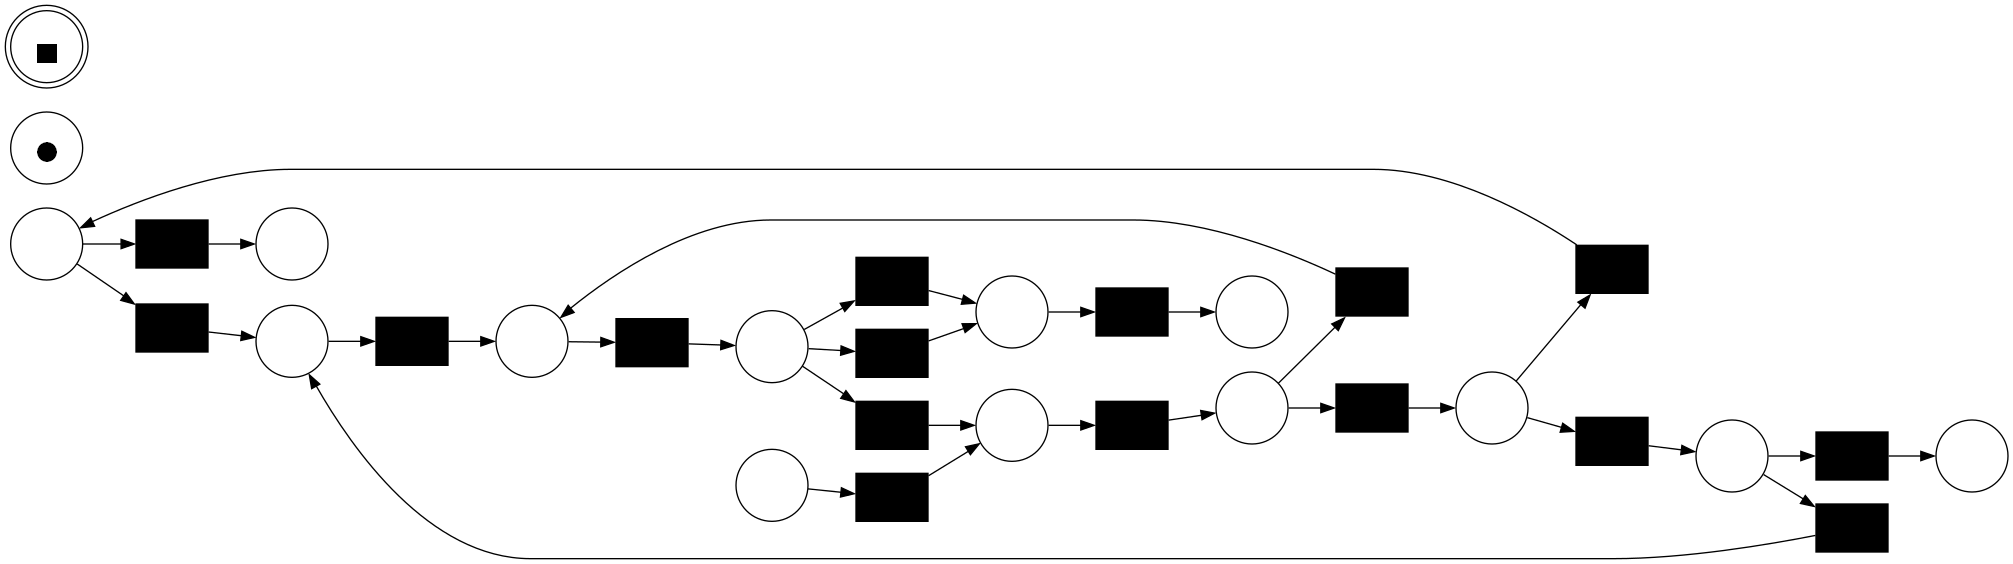

In [16]:
view_petri_net(pn, i, f)